# Util

In [36]:
# !python -m pip install tensorflow keras
# !python -m pip install scikit-learn
# !python -m pip install nltk

In [37]:
# !pip install tensorflow==2.8.2

In [38]:
# !pip install --upgrade tensorflow scikeras keras

In [39]:
# import tensorflow as tf
# print("Version de TensorFlow:", tf.__version__)

# tf.config.list_physical_devices()

In [40]:
# import tensorflow as tf
# tf.config.experimental.list_physical_devices()
# tf.config.list_physical_devices()
# tf.test.gpu_device_name()

In [41]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import

In [42]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten,BatchNormalization,MaxPooling1D,SpatialDropout1D
from keras import regularizers
from keras import utils
from keras.callbacks import EarlyStopping

import re
import os
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Coder le texte

## Récupération des textes et des années de publications (labels)

In [43]:
def GetDataBooks(chemin):
    # Récupérer la liste des noms de fichiers dans le dossier
    fichiers = os.listdir(chemin)
    
    # Initialiser une liste pour stocker les textes
    books = []

    # Initialiser une liste pour stocker les années extraites des noms de fichiers
    y = []

    # Parcourir les fichiers et lire leur contenu
    for fichier in fichiers:
        chemin_fichier = os.path.join(chemin, fichier)
        with open(chemin_fichier, 'r', encoding='utf-8') as f:

            texte = f.read()

            # Extraire l'année du nom de fichier
            annee = re.search(r'\((\d{4})\)', fichier)  # Utilisation d'une expression régulière pour trouver l'année entre parenthèses
            # Si une année est trouvée, alors nous pouvons étudier le livre, nous l'ajoutons ainsi que son label dans les listes associées
            if annee:
                books.append(texte)
                annee_int = int(annee.group(1)) # Récupérer l'année
                y.append(annee_int)  # Ajouter l'année extraite à la liste des labels
    return books,y

In [44]:
# Définition de la seed pour la reproductibilité des résultats
utils.set_random_seed(42)

# Chemin des dossier contenant les textes
dossier_train = 'train'
dossier_test = 'test'
dossier_val = 'validation'

X_train,y_train = GetDataBooks(dossier_train)
X_val,y_val = GetDataBooks(dossier_val)
X_test,y_test = GetDataBooks(dossier_test)

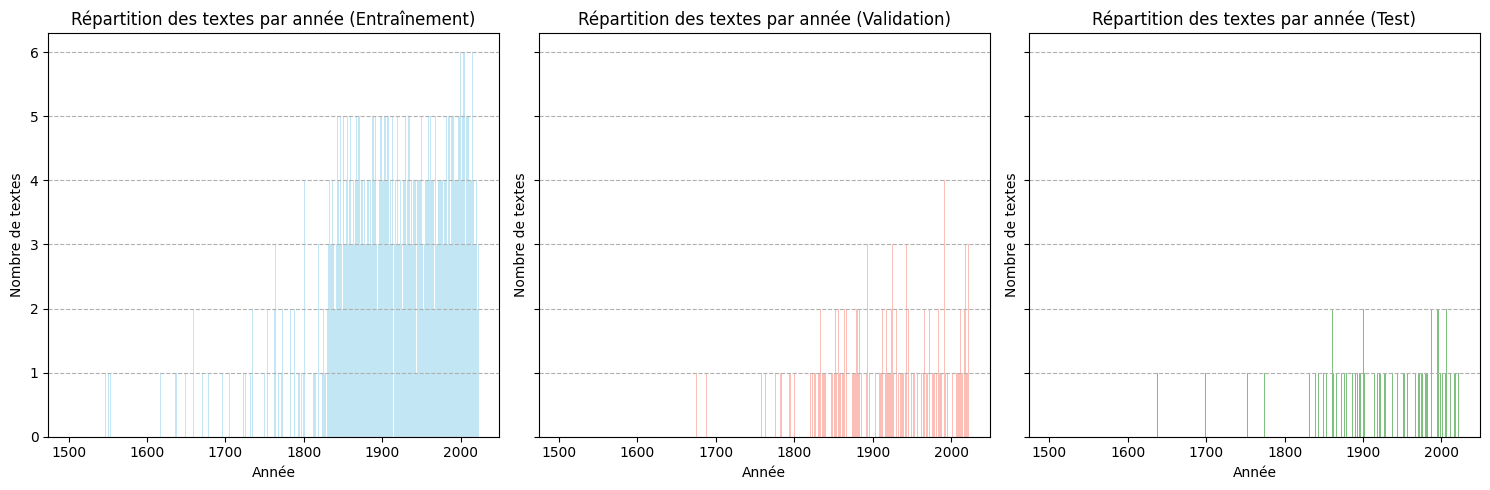

In [45]:
# Calculer la plage maximale des valeurs Y sur les trois ensembles de données
max_y = max(max(y_train), max(y_val), max(y_test))
min_y = min(min(y_train), min(y_val), min(y_test))

# Créer des sous-graphiques avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Tracer l'histogramme pour les données d'entraînement
axs[0].hist(y_train, bins=range(min_y, max_y + 1), alpha=0.5, color='skyblue')
axs[0].grid(axis='y', linestyle='--')
axs[0].set_xlabel('Année')
axs[0].set_ylabel('Nombre de textes')
axs[0].set_title('Répartition des textes par année (Entraînement)')

# Tracer l'histogramme pour les données de validation
axs[1].hist(y_val, bins=range(min_y, max_y + 1), alpha=0.5, color='salmon')
axs[1].grid(axis='y', linestyle='--')
axs[1].set_xlabel('Année')
axs[1].set_ylabel('Nombre de textes')
axs[1].set_title('Répartition des textes par année (Validation)')

# Tracer l'histogramme pour les données de test
axs[2].hist(y_test, bins=range(min_y, max_y + 1), alpha=0.5, color='green')
axs[2].grid(axis='y', linestyle='--')
axs[2].set_xlabel('Année')
axs[2].set_ylabel('Nombre de textes')
axs[2].set_title('Répartition des textes par année (Test)')

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Afficher les graphiques
plt.show()


## Tokenization + division en sequence

### Classe Fonction et Variable

In [46]:
# Longueur maximale des séquences
max_len = 5000

In [47]:
class WordTokenizer:
    def __init__(self, dict_word=None):
        if dict_word is None:
            self.dict_word = {}
            self.next_number = 1
        else:
            self.dict_word = dict_word
            self.next_number = len(dict_word)

    def fit(self,list_of_texts):
        total_texts = len(list_of_texts)
        for i, text in enumerate(list_of_texts):
            # Les textes sont déjà pré traité (tout est déjà en minuscule)
            # text = text.lower()
            tokens = word_tokenize(text)

            for token in tokens:
                if token not in self.dict_word:
                    self.dict_word[token] = [self.next_number,1]
                    self.next_number += 1
                else:
                    self.dict_word[token] = [self.dict_word[token][0],self.dict_word[token][1]+1]

            percentage = (i + 1) / total_texts * 100
            print(f"Progress: {percentage:.2f}% complete")

        print("\nTokenization complete.")
    
    def tokenize(self, list_of_texts):
        total_texts = len(list_of_texts)
        token_lists = []
        for i, text in enumerate(list_of_texts):
            tokens = word_tokenize(text)
            token_lists.append([])

            for token in tokens:
                if token not in self.dict_word:
                    token_lists[-1].append([0,0])
                else:
                    token_lists[-1].append(self.dict_word[token])

            percentage = (i + 1) / total_texts * 100
            print(f"Progress: {percentage:.2f}% complete")

        print("\nTokenization complete.")
        return token_lists, self.next_number

In [48]:
def diviser_liste(liste,labels, taille):
    resultats = []
    res_labels = []
    ind = 0
    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if(longueur<taille):
            ind+=1
            continue
        nbtour = round(longueur/taille)
        lastpos=0
        # Division de la sous-liste en morceaux de taille spécifiée
        for i in range(nbtour):
            if(lastpos + taille > longueur):
              if((lastpos + taille)-longueur < max_len/2):
                  continue
              lastpos -= (lastpos + taille)-longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos = lastpos + taille
            resultats.append(resultat)

            # A chaque fois que je divisie, jajoute le label au meme indice
            res_labels.append(labels[ind])
        ind+=1

    return resultats,res_labels

### Création du tokenizer + sauvegarde du dictionnaire

In [49]:
# tokenizer = WordTokenizer()
# tokenizer.fit(X_train)
# tokenizer.fit(X_val)

In [50]:
# import json

# # Chemin du fichier de sauvegarde
# file_path = "dict_word.json"

# # Sauvegarde du dictionnaire en JSON dans un fichier
# with open(file_path, "w") as json_file:
#     json.dump(tokenizer.dict_word, json_file)

### Récupération dico + Création du tokenizer 

In [51]:
import json

# Chemin du fichier JSON à lire
file_path = "dict_word.json"

ditc_word = {}
# Lecture du fichier JSON
with open(file_path, "r") as json_file:
    ditc_word = json.load(json_file)

tokenizer = WordTokenizer(dict_word=ditc_word)

In [52]:
# Utilisation d'une compréhension de liste pour afficher les 100 premiers éléments
first_100 = {word: tokenizer.dict_word[word] for word in list(tokenizer.dict_word.keys())[:100]}
print(first_100)

{'barbara': [1, 213], 'abel': [2, 206], 'derrière': [3, 19480], 'la': [4, 1566710], 'haine': [5, 4489], 'fleuve': [6, 2609], 'noir': [7, 12546], 'mille': [8, 17332], 'mercis': [9, 28], 'à': [10, 1216092], 'jean': [11, 14818], 'paul': [12, 9481], 'qui': [13, 567337], ',': [14, 4950538], 'l': [15, 1035485], 'autre': [16, 82406], 'bout': [17, 20241], 'du': [18, 409729], 'monde': [19, 45577], 'm': [20, 206749], 'a': [21, 297991], 'été': [22, 70755], 'd': [23, 792554], 'une': [24, 616692], 'aide': [25, 6512], 'précieuse': [26, 1017], '.': [27, 3248343], 'laetitia': [28, 781], 'avait': [29, 308219], 'réussi': [30, 3618], 'un': [31, 859690], 'créneau': [32, 101], 'parfait': [33, 2801], 'premier': [34, 22175], 'coup': [35, 35410], 'ce': [36, 427443], 'pourtant': [37, 21527], 'n': [38, 408597], 'adoucit': [39, 192], 'pas': [40, 566204], 'son': [41, 356461], 'humeur': [42, 4689], 'éteins': [43, 91], 'ta': [44, 20471], 'nintendo': [45, 9], 'milo': [46, 436], 'on': [47, 280079], 'est': [48, 555806

### Training Data

In [53]:
# Transformation de chaque texte dans X_train en une séquence d'entiers
sequences, token_number = tokenizer.tokenize(X_train)

Progress: 0.12% complete
Progress: 0.24% complete
Progress: 0.37% complete
Progress: 0.49% complete
Progress: 0.61% complete
Progress: 0.73% complete
Progress: 0.85% complete
Progress: 0.98% complete
Progress: 1.10% complete
Progress: 1.22% complete
Progress: 1.34% complete
Progress: 1.46% complete
Progress: 1.59% complete
Progress: 1.71% complete
Progress: 1.83% complete
Progress: 1.95% complete
Progress: 2.07% complete
Progress: 2.20% complete
Progress: 2.32% complete
Progress: 2.44% complete
Progress: 2.56% complete
Progress: 2.68% complete
Progress: 2.80% complete
Progress: 2.93% complete
Progress: 3.05% complete
Progress: 3.17% complete
Progress: 3.29% complete
Progress: 3.41% complete
Progress: 3.54% complete
Progress: 3.66% complete
Progress: 3.78% complete
Progress: 3.90% complete
Progress: 4.02% complete
Progress: 4.15% complete
Progress: 4.27% complete
Progress: 4.39% complete
Progress: 4.51% complete
Progress: 4.63% complete
Progress: 4.76% complete
Progress: 4.88% complete


In [54]:
# Division des données en séquences de longueur maximale max_len
data_train, y_train = diviser_liste(sequences, y_train, max_len)

# Conversion en tableau numpy
y_train = np.array(y_train)
data_train = np.array(data_train)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_train))

# Affichage du nombre total d'index dans le tokenizer
print("Nombre total d'index dans le tokenizer:", token_number)

Nombre de séquences de données: 11811
Nombre total d'index dans le tokenizer: 291389


### Validation Data

In [55]:
sequences_val, token_number = tokenizer.tokenize(X_val)

Progress: 0.61% complete
Progress: 1.23% complete
Progress: 1.84% complete
Progress: 2.45% complete
Progress: 3.07% complete
Progress: 3.68% complete
Progress: 4.29% complete
Progress: 4.91% complete
Progress: 5.52% complete
Progress: 6.13% complete
Progress: 6.75% complete
Progress: 7.36% complete
Progress: 7.98% complete
Progress: 8.59% complete
Progress: 9.20% complete
Progress: 9.82% complete
Progress: 10.43% complete
Progress: 11.04% complete
Progress: 11.66% complete
Progress: 12.27% complete
Progress: 12.88% complete
Progress: 13.50% complete
Progress: 14.11% complete
Progress: 14.72% complete
Progress: 15.34% complete
Progress: 15.95% complete
Progress: 16.56% complete
Progress: 17.18% complete
Progress: 17.79% complete
Progress: 18.40% complete
Progress: 19.02% complete
Progress: 19.63% complete
Progress: 20.25% complete
Progress: 20.86% complete
Progress: 21.47% complete
Progress: 22.09% complete
Progress: 22.70% complete
Progress: 23.31% complete
Progress: 23.93% complete
Pr

In [56]:
data_val,y_val = diviser_liste(sequences_val,y_val,max_len)

# Convertir en tableau numpy
y_val = np.array(y_val)
data_val = np.array(data_val)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_val))

# Affichage du nombre total d'index dans le tokenizer
print("Nombre total d'index dans le tokenizer:", token_number)

Nombre de séquences de données: 2439
Nombre total d'index dans le tokenizer: 291389


### Test Data

In [57]:
# Transformation de chaque texte dans X_test en une séquence d'entiers
sequences_test, _ = tokenizer.tokenize(X_test)

Progress: 1.45% complete
Progress: 2.90% complete
Progress: 4.35% complete
Progress: 5.80% complete
Progress: 7.25% complete
Progress: 8.70% complete
Progress: 10.14% complete
Progress: 11.59% complete
Progress: 13.04% complete
Progress: 14.49% complete
Progress: 15.94% complete
Progress: 17.39% complete
Progress: 18.84% complete
Progress: 20.29% complete
Progress: 21.74% complete
Progress: 23.19% complete
Progress: 24.64% complete
Progress: 26.09% complete
Progress: 27.54% complete
Progress: 28.99% complete
Progress: 30.43% complete
Progress: 31.88% complete
Progress: 33.33% complete
Progress: 34.78% complete
Progress: 36.23% complete
Progress: 37.68% complete
Progress: 39.13% complete
Progress: 40.58% complete
Progress: 42.03% complete
Progress: 43.48% complete
Progress: 44.93% complete
Progress: 46.38% complete
Progress: 47.83% complete
Progress: 49.28% complete
Progress: 50.72% complete
Progress: 52.17% complete
Progress: 53.62% complete
Progress: 55.07% complete
Progress: 56.52% c

In [58]:
data_test,y_test = diviser_liste(sequences_test,y_test,max_len)

# Convertir en tableau numpy
y_test = np.array(y_test)
data_test = np.array(data_test)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_test))

Nombre de séquences de données: 1040


### Affichage informations

In [59]:
print("Nombre de séquences de données (Training):", len(data_train))
print("Nombre de séquences de données (Validation):", len(data_val))
print("Nombre de séquences de données (Test):", len(data_test))

Nombre de séquences de données (Training): 11811
Nombre de séquences de données (Validation): 2439
Nombre de séquences de données (Test): 1040


### Binary Conversion (a la place de lembedding = mauvais)

In [51]:
# def int_to_binary_list(number, max_bits):
#     # Convertir l'entier en chaîne binaire en enlevant le préfixe '0b'
#     binary_string = bin(number)[2:]

#     # Ajouter des zéros à gauche pour atteindre le nombre maximal de bits
#     padded_binary_string = binary_string.zfill(max_bits)

#     # Convertir la chaîne binaire en tableau NumPy d'entiers
#     binary_array = np.array([int(bit) for bit in padded_binary_string])

#     return binary_array

# # Fonction pour convertir chaque entier d'un tableau NumPy en sa représentation binaire
# def array_of_ints_to_binary_list(array_of_ints, max_bits):
#     binary_representation = np.array([int_to_binary_list(num, max_bits) for sublist in array_of_ints for num in sublist])
#     binary_representation = binary_representation.reshape(array_of_ints.shape[0], array_of_ints.shape[1], max_bits)
#     return binary_representation

# # Exemple d'utilisation avec un tableau NumPy
# array_of_ints = data
# max_bits = 19  # Nombre maximum de bits pour représenter 272877

# resultat = array_of_ints_to_binary_list(array_of_ints, max_bits)
# print(resultat)

# Définition des architectures des modeles testés

In [140]:
# # Construction du modèle
# # Pilee linéaire de couches. Dans ce modèle, les données passent à travers les couches dans l'ordre où elles ont été ajoutées.
# model = Sequential()
# # L'embedding est une représentation dense des mots (ou des tokens) dans un espace vectoriel.
# # L'objectif principal de l'embedding est de capturer les similarités sémantiques entre les mots en les plaçant dans un espace vectoriel où les mots ayant des significations similaires sont plus proches les uns des autres.
# model.add(Embedding(max_words, embedding_dim, input_length=max_len))

# # Couche de convolution à une dimension (1D) au modèle. Cette couche va utiliser 128 filtres de taille 10 avec une fonction d'activation ReLU (Rectified Linear Unit).
# # La convolution 1D est utilisée pour extraire des caractéristiques séquentielles des données.
# model.add(Conv1D(128,10, activation='relu'))

# # Le pooling global maximale extrait les caractéristiques les plus significatives de chaque canal de la sortie de la couche précédente, réduisant ainsi la dimensionnalité des données.
# model.add(GlobalMaxPooling1D())

# # Couche dense (entièrement connectée) au modèle avec 128 neurones et une fonction d'activation ReLU.
# model.add(Dense(128, activation='relu'))

# # Le dropout est une technique de régularisation qui désactive aléatoirement un pourcentage (dans ce cas, 50%) des neurones de la couche précédente pendant l'entraînement,
# # ce qui aide à prévenir le surapprentissage.
# model.add(Dropout(0.5))

# # Couche dense de sortie au modèle avec un seul neurone et une fonction d'activation linéaire.
# # Dans ce cas, la sortie est une seule valeur, qui est la date de publication prédite.
# model.add(Dense(1, activation='linear'))

# # La fonction ReLU est couramment utilisée dans les réseaux de neurones en raison de sa simplicité et de sa capacité à introduire une non-linéarité dans le modèle,
# # ce qui permet au réseau de capturer des motifs complexes dans les données.

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# model.summary()

# # Entraînement du modèle
# model.fit(data, y_train, epochs=50, batch_size=32)
# #, validation_split=0.2
# # Après l'entraînement, vous pouvez utiliser le modèle pour prédire la date de publication d'un nouveau livre.


In [73]:
embedding_dim = 10

def archi(model_params,input_shape):
    model = Sequential()

    model.add(Embedding(input_dim=token_number, output_dim=model_params['embedding_dim'],input_shape=input_shape))

    model.add(Reshape(target_shape=(max_len, model_params['embedding_dim'] * 2)))

    model.add(Conv1D(filters=model_params['conv1D_1_filters'], kernel_size=model_params['conv1D_1_kernel'], activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    
    if(model_params['pool_size'] != 0):
        model.add(MaxPooling1D(pool_size=model_params['pool_size']))

    if(model_params['dense_units'] != 0):
        model.add(Dense(units=model_params['dense_units'],kernel_regularizer=regularizers.l2(l=0.01)))

    if(model_params['dropout'] != 0):
        model.add(Dropout(rate=model_params['dropout']))

    model.add(Flatten())

    model.add(Dense(units=1))
    return model

def archi_3CONV32_F_DE_DR_DE(input_shape):
    """
    Fonction définissant l'architecture du modèle avec 3 couches de convolution.

    Returns:
    - model: Modèle Keras Sequential défini avec les couches spécifiées.
    """
    # Pile linéaire de couches. 
    # Dans ce modèle, les données passent à travers les couches dans l'ordre où elles ont été ajoutées.
    model = Sequential()

    # L'embedding est une représentation dense des mots (ou des tokens) dans un espace vectoriel.
    # L'objectif principal de l'embedding est de capturer les similarités sémantiques entre les mots en les plaçant
    # dans un espace vectoriel où les mots ayant des significations similaires sont plus proches les uns des autres.
    # input_dim le nombre de vocabulaire, input_length le nombre d'éléments dans une liste, output_dim la dimension de
    # chaque vecteur.
    model.add(Embedding(input_dim=token_number, output_dim=embedding_dim, input_length=max_len,input_shape=input_shape))
    model.add(Reshape((max_len, 10 * 2)))

    # Couche de convolution à une dimension (1D) au modèle.
    # Cette couche va utiliser 16 filtres de taille 9 avec une fonction d'activation ReLU (Rectified Linear Unit).
    model.add(Conv1D(32, 9, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Deuxième couche de convolution avec 32 filtres de taille 7 et activation ReLU.
    model.add(Conv1D(64, 7, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Troisième couche de convolution avec 64 filtres de taille 3 et activation ReLU.
    model.add(Conv1D(128, 5, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Couche dense de 512 neurones avec activation ReLU et régularisation L2.
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1)))

    # Dropout pour éviter le surapprentissage.
    model.add(Dropout(0.05))

    # Transformation des données en un format adapté à une couche Dense.
    model.add(Flatten())

    # Couche de sortie avec une seule sortie.
    model.add(Dense(1))

    return model



# La fonction ReLU est couramment utilisée dans les réseaux de neurones en raison de sa simplicité et de sa capacité à introduire une non-linéarité dans le modèle,
# ce qui permet au réseau de capturer des motifs complexes dans les données.

# Entrainement des models

## Ou en entrainer un seul

### Test avec plusieurs params

In [57]:
# import random

# # Create a list to store 50 model_params
# list_of_params = []

# # Define the range of values for each parameter
# embedding_dim_range = range(5, 15)  # Change the range as needed
# conv1D_1_filters_range = range(32, 256)  # Change the range as needed
# conv1D_1_kernel_range = range(5, 101)  # Change the range as needed

# # Iterate to create 50 model_params with random values
# for _ in range(50):
#     # Generate random values for each parameter
#     embedding_dim = random.choice(embedding_dim_range)
#     conv1D_1_filters = random.choice(conv1D_1_filters_range)
#     conv1D_1_kernel = random.choice(conv1D_1_kernel_range)
    
#     # Create a dictionary for the current model_params
#     params = {
#         'embedding_dim': embedding_dim,
#         'conv1D_1_filters': conv1D_1_filters,
#         'conv1D_1_kernel': conv1D_1_kernel
#     }
    
#     # Append the params to the list_of_params
#     list_of_params.append(params)

In [58]:
# def compile(model_params):
#     utils.set_random_seed(42)

#     # Création du modèle en utilisant l'architecture spécifiée
#     model = archi(model_params)

#     # Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     # Affichage de la structure du modèle
#     model.summary()

#     # Création du callback EarlyStopping pour surveiller la perte d'entraînement
#     early_stopping = EarlyStopping(monitor='loss', patience=3)

#     # Création du callback EarlyStopping pour surveiller la perte de validation
#     early_stopping_val = EarlyStopping(monitor='val_loss', patience=3)

#     # Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
#     history = model.fit(data_train, y_train, epochs=200, batch_size=32, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

#     return model,history

In [59]:
# def evaluate(model,model_params):
#     # Evaluate the model on the test data
#     print("Evaluation on Test Data:")
#     loss_test,mae_test = model.evaluate(data_test, y_test)
#     print()

#     # Evaluate the model on the training data
#     print("Evaluation on Training Data:")
#     loss_train,mae_train = model.evaluate(data_train, y_train)
#     print()

#     # Evaluate the model on the validation data
#     print("Evaluation on Validation Data:")
#     loss_validation,mae_validation = model.evaluate(data_val, y_val)
#     print()

#     # Charger les données à partir du fichier CSV
#     df_models = pd.read_csv('df_models.csv')

#     nouvelle_ligne = [mae_test,loss_test,mae_train,loss_train,mae_validation,loss_validation,
#                     model_params['embedding_dim'],model_params['conv1D_1_filters'],model_params['conv1D_1_kernel']]

#     # Ajouter la nouvelle ligne à la DataFrame
#     df_models.loc[len(df_models)] = nouvelle_ligne

#     df_models.to_csv('df_models.csv', index=False)

#     # Afficher les données mises à jour
#     #display(df_models)

In [60]:
# for model_params in list_of_params:
#     model,history = compile(model_params)
#     evaluate(model,model_params)

In [61]:
df_models = pd.read_csv('df_models.csv')
display(df_models)

,Test_MAE,Test_MSE,Train_MAE,Train_MSE,Val_MAE,Val_MSE,embedding_dim,conv1D_1_filters,conv1D_1_kernel
0,21.231134,814.542419,0.668971,0.916312,19.410280,713.596619,10.0,32.0,9.0
1,23.095755,1275.975098,1.803560,6.659859,25.241987,1215.574951,10.0,32.0,21.0
2,25.501158,1566.790771,5.923900,64.913734,28.319826,1571.092773,10.0,32.0,31.0
3,25.728455,1648.863770,5.700406,60.525574,28.680996,1613.620972,10.0,32.0,41.0
4,27.242691,1805.061646,3.703882,23.175650,30.969715,1788.279907,10.0,32.0,101.0
5,32.056061,2134.288574,0.837420,1.714122,33.010803,1952.237427,10.0,32.0,301.0
6,22.383560,1001.229858,1.998984,8.208273,22.873327,1027.974854,10.0,64.0,9.0
7,21.825577,839.235046,1.396211,4.365321,22.282118,909.433533,10.0,128.0,9.0
8,44.220734,3358.853516,23.981670,763.511475,38.911728,2656.657227,12.0,167.0,37.0
9,27.607544,1608.436035,15.332014,368.328857,29.077618,1807.905029,13.0,252.0,6.0


### Un seul

In [62]:
def scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 2
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [136]:
from keras.callbacks import LearningRateScheduler

utils.set_random_seed(1)

model_params = {'embedding_dim': 10, 'conv1D_1_filters': 64,'conv1D_1_kernel': 9,'pool_size':2,'dense_units': 32,'dropout':0.8 }

# Création du modèle en utilisant l'architecture spécifiée
input_shape = (max_len, 2)
model = archi(model_params,input_shape)
#model = archi_3CONV32_F_DE_DR_DE(input_shape=input_shape)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Affichage de la structure du modèle
#model.summary()

# Création du callback EarlyStopping pour surveiller la perte d'entraînement
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Création du callback EarlyStopping pour surveiller la perte de validation
early_stopping_val = EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
history = model.fit(data_train, y_train, epochs=200, batch_size=64, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

# L'historique de l'entraînement
history.history

Epoch 1/200
185/185 [==============================] - 65s 302ms/step - loss: 196742.2812 - mae: 191.2534 - val_loss: 2144.6548 - val_mae: 35.2782
Epoch 2/200
185/185 [==============================] - 51s 274ms/step - loss: 1147.6481 - mae: 24.3083 - val_loss: 1806.5803 - val_mae: 32.4278
Epoch 3/200
185/185 [==============================] - 51s 274ms/step - loss: 612.4419 - mae: 16.9611 - val_loss: 1620.6011 - val_mae: 30.1871
Epoch 4/200
185/185 [==============================] - 51s 274ms/step - loss: 453.0936 - mae: 13.2714 - val_loss: 1546.6001 - val_mae: 29.4246
Epoch 5/200
185/185 [==============================] - 51s 274ms/step - loss: 345.0389 - mae: 11.2349 - val_loss: 1497.3210 - val_mae: 29.1122
Epoch 6/200
185/185 [==============================] - 51s 274ms/step - loss: 298.4399 - mae: 10.5311 - val_loss: 1455.9620 - val_mae: 28.3789
Epoch 7/200
185/185 [==============================] - 51s 274ms/step - loss: 254.2404 - mae: 9.8495 - val_loss: 1413.2670 - val_mae: 28.

{'loss': [196742.28125,
  1147.6480712890625,
  612.44189453125,
  453.09356689453125,
  345.0389099121094,
  298.43988037109375,
  254.24044799804688,
  276.0612487792969,
  262.4917907714844,
  223.3876495361328,
  234.49432373046875,
  300.25909423828125,
  326.2220458984375],
 'mae': [191.25340270996094,
  24.308311462402344,
  16.9610652923584,
  13.271405220031738,
  11.234931945800781,
  10.531068801879883,
  9.849530220031738,
  9.88088607788086,
  9.278702735900879,
  9.855144500732422,
  9.86880874633789,
  11.502097129821777,
  12.723212242126465],
 'val_loss': [2144.65478515625,
  1806.580322265625,
  1620.60107421875,
  1546.60009765625,
  1497.321044921875,
  1455.9620361328125,
  1413.2669677734375,
  1415.61669921875,
  1429.5821533203125,
  1346.3470458984375,
  1372.033935546875,
  1554.006591796875,
  1709.305908203125],
 'val_mae': [35.27816390991211,
  32.42776107788086,
  30.187057495117188,
  29.424633026123047,
  29.11222267150879,
  28.378875732421875,
  28.037

In [ ]:
# # Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
# history = model.fit(data_train, y_train, epochs=10, batch_size=32, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

# # L'historique de l'entraînement
# history.history

# Evaluation du model

In [137]:
# Evaluate the model on the test data
print("Evaluation on Test Data:")
loss_test,mae_test = model.evaluate(data_test, y_test)
print()

# Evaluate the model on the training data
print("Evaluation on Training Data:")
loss_train,mae_train = model.evaluate(data_train, y_train)
print()

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
loss_validation,mae_validation = model.evaluate(data_val, y_val)
print()

Evaluation on Test Data:
33/33 [==============================] - 1s 32ms/step - loss: 2948.2717 - mae: 40.7188

Evaluation on Training Data:
370/370 [==============================] - 11s 30ms/step - loss: 491.7011 - mae: 19.1519

Evaluation on Validation Data:
77/77 [==============================] - 2s 30ms/step - loss: 1709.3058 - mae: 32.0324



# Save in Datas

## Calculate Accuracy

In [138]:
y_pred = model.predict(data_test)

error_samples = []
tolerance = 15
within_tolerance_count = 0

for i in range(len(y_test)):
    if abs(round(y_pred[i][0]) - y_test[i]) <= tolerance:
        within_tolerance_count += 1

accuracy_within_tolerance = (within_tolerance_count / len(y_test)) * 100

33/33 [==============================] - 1s 28ms/step


## Create file

In [86]:
# df_models = pd.DataFrame()

# df_models['Model Name'] = ["Model 1"]
# df_models['MAE'] = [mae_test]
# df_models['MSE'] = [loss_test]
# df_models['Accuracy with tolerance 15 (%)'] = [accuracy_within_tolerance]
# # df_models['Train_MAE'] = [mae_train]
# # df_models['Train_MSE'] = [loss_train]
# # df_models['Val_MAE'] = [mae_validation]
# # df_models['Val_MSE'] = [loss_validation]

# # Add columns for each element in model_params
# for key, value in model_params.items():
#     df_models[key] = value

# df_models.to_csv('df_models.csv', index=False)

# # Afficher les données
# display(df_models)

,Model Name,MAE,MSE,Accuracy with tolerance 15 (%),embedding_dim,conv1D_1_filters,conv1D_1_kernel,pool_size,dense_units,dropout
0,Model 1,22.06307,950.560364,48.173077,10,64,9,2,32,0.4


## Add data

In [105]:
# # Pour supprimer une mauvaise ligne
# # Charger les données à partir du fichier CSV
# df_models = pd.read_csv('df_models.csv')
# df_models.drop(len(df_models)-1, inplace=True)
# display(df_models)
# df_models.to_csv('df_models.csv', index=False)

,Model Name,MAE,MSE,Accuracy with tolerance 15 (%),embedding_dim,conv1D_1_filters,conv1D_1_kernel,pool_size,dense_units,dropout
0,Model 1,22.063070,950.560364,48.173077,10,64,9,2,32,0.4
1,Model 2,22.810202,1014.273804,44.519231,10,64,9,0,32,0.0


In [139]:
# Charger les données à partir du fichier CSV
df_models = pd.read_csv('df_models.csv')
model_name = "Model "+str(len(df_models)+1)
nouvelle_ligne = [model_name,
                  mae_test,
                  loss_test,
                  accuracy_within_tolerance,
                  model_params['embedding_dim'],
                  model_params['conv1D_1_filters'],
                  model_params['conv1D_1_kernel'],
                  model_params['pool_size'],
                  model_params['dense_units'],
                  model_params['dropout']]

# Ajouter la nouvelle ligne à la DataFrame
df_models.loc[len(df_models)] = nouvelle_ligne

df_models.to_csv('df_models.csv', index=False)

# Afficher les données mises à jour
display(df_models)

,Model Name,MAE,MSE,Accuracy with tolerance 15 (%),embedding_dim,conv1D_1_filters,conv1D_1_kernel,pool_size,dense_units,dropout
0,Model 1,22.063070,950.560364,48.173077,10,64,9,2,32,0.4
1,Model 2,22.810202,1014.273804,44.519231,10,64,9,0,32,0.0
2,Model 3,23.583460,1128.512939,44.134615,10,64,21,2,32,0.4
3,Model 4,28.019279,1690.051880,38.461538,10,64,101,2,32,0.4
4,Model 5,21.885794,1028.734985,47.980769,10,256,9,2,32,0.4
5,Model 6,22.424904,898.838074,42.692308,10,64,9,2,256,0.4
6,Model 7,22.706444,1007.537842,46.634615,10,64,9,2,32,0.6
7,Model 8,21.387081,918.364624,48.365385,10,64,9,2,32,0.8
8,Model 9,40.718819,2948.271729,20.480769,10,256,101,2,256,0.8


# Predictions

In [140]:
# Utiliser le modèle pour prédire les dates sur les données de test
predictions = model.predict(data_test)

# Afficher les dates prédites
print("Dates prédites :")
for prediction in predictions:
    print(prediction)

33/33 [==============================] - 2s 58ms/step
Dates prédites :
[1983.3334]
[1970.0731]
[1943.1138]
[1951.6062]
[1942.3202]
[1956.0758]
[1984.9694]
[1965.4731]
[1941.5614]
[1951.9586]
[1974.0647]
[1987.2639]
[1966.4502]
[1966.5819]
[1977.1854]
[1941.4407]
[1985.4833]
[1972.4927]
[1980.6255]
[1969.4377]
[1996.0121]
[2003.3732]
[1980.853]
[1979.5867]
[1988.5117]
[2002.3911]
[1998.7924]
[1962.4276]
[2003.1427]
[1991.8615]
[1987.7524]
[1976.6772]
[2024.324]
[1984.4254]
[2006.3323]
[2008.7278]
[1988.7891]
[1971.674]
[1804.1754]
[1804.1632]
[1796.0977]
[1798.0391]
[1800.6843]
[1803.8734]
[1793.5381]
[1792.5895]
[1845.2544]
[1845.3148]
[1829.7028]
[1850.598]
[1846.4485]
[1838.2662]
[1822.961]
[1848.865]
[1835.2861]
[1841.6212]
[1841.9512]
[1846.2361]
[1833.1141]
[1794.8839]
[1815.4757]
[1817.2898]
[1816.9025]
[1815.7173]
[1810.9288]
[1797.6833]
[1812.436]
[1827.3042]
[1807.0259]
[1789.9625]
[1802.8767]
[1869.5206]
[1833.8826]
[1832.103]
[1830.742]
[1851.4409]
[1832.05]
[1830.1254]
[183

# Graphes

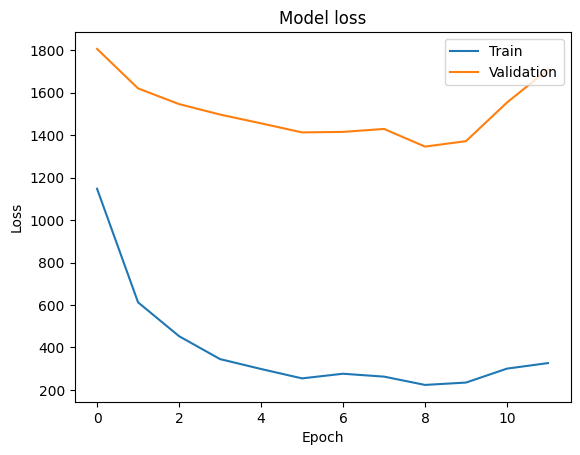

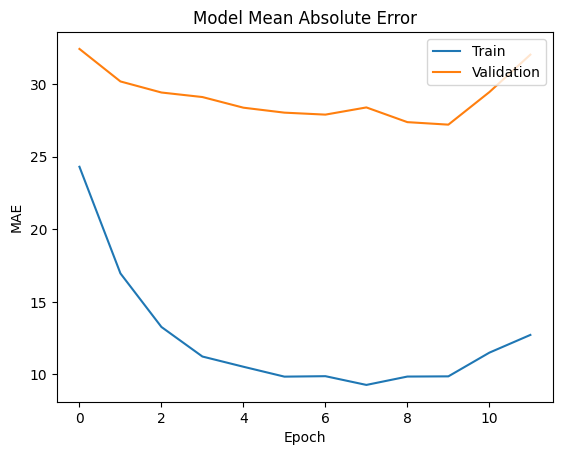

33/33 [==============================] - 2s 58ms/step


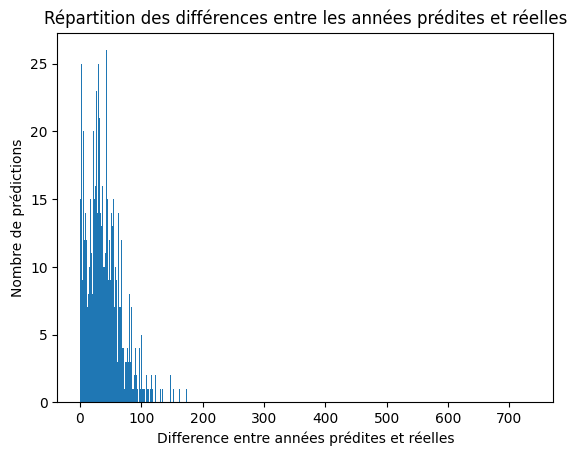

33/33 [==============================] - 2s 59ms/step
Accuracy avec exacte matching: 0.4807692307692308 %
Accuracy avec tolerance de 15 est: 20.48076923076923 %


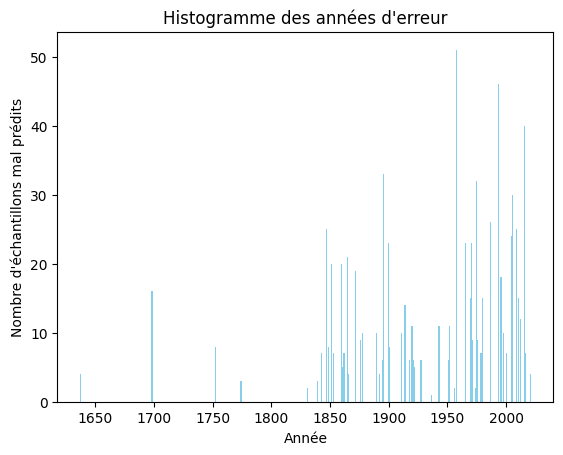

In [141]:
# Plot training & validation loss values
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Plot MAE
plt.plot(history.history['mae'][1:]) 
plt.plot(history.history['val_mae'][1:]) 
plt.title('Model Mean Absolute Error') 
plt.ylabel('MAE') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

#Calcul de la différence entre les années prédites et les années réelles
y_pred = model.predict(data_test) 
diff = np.abs(y_test - y_pred.flatten())

#le dernier bin
max_diff = np.max(diff)

#Plot de l'histogramme des différences entre les années prédites et réelles
plt.hist(diff, bins=np.arange(0,max_diff,1)) 
plt.xlabel('Difference entre années prédites et réelles') 
plt.ylabel('Nombre de prédictions') 
plt.title('Répartition des différences entre les années prédites et réelles') 
plt.show()


#-----------------------------------voir quelle année est la plus dure----------------------------------#
y_pred = model.predict(data_test)
error_samples = []
exact_matches_count = 0

for i in range(len(y_test)):
    if round(y_pred[i][0]) != y_test[i]:
        error_samples.append(y_test[i])
    else:
        exact_matches_count += 1

accuracy_exact_matches = (exact_matches_count / len(y_test)) * 100

print("Accuracy avec exacte matching:", accuracy_exact_matches, "%")


#------------------------voir quelle année est la plus dure (tolerance de 15)---------------------------#
error_samples = []
tolerance = 15
within_tolerance_count = 0

for i in range(len(y_test)):
    if abs(round(y_pred[i][0]) - y_test[i]) > tolerance:
        error_samples.append(y_test[i])
    else:
        within_tolerance_count += 1

accuracy_within_tolerance = (within_tolerance_count / len(y_test)) * 100

print("Accuracy avec tolerance de", tolerance, "est:", accuracy_within_tolerance, "%")


# Créer un histogramme des années d'erreur
plt.hist(error_samples, bins=max(y_test)-min(y_test)+1, color='skyblue')
plt.xlabel('Année')
plt.ylabel('Nombre d\'échantillons mal prédits')
plt.title('Histogramme des années d\'erreur')
plt.show()

# Load & Save Model

In [40]:
# Sauvegarder le modèle complet au format HDF5
#model.save('modelV5.h5')

In [41]:
# Charger le modèle complet
# from keras.models import load_model
# model = load_model('modelV4.h5')

# model.summary()